# Regression Analysis

This code shows the main steps of using Regression to predict housing price.

## Setup

First of all, we need to import the following libraries.

In [1]:
# pip install lime

In [2]:
## for data
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
## for explainer
from lime import lime_tabular

Then we read the data into a pandas Dataframe. The original dataset contains 81 columns, but in this code, we will work with a subset of 12 columns.

In [3]:
dtf = pd.read_csv("HousePrice-train.csv")
cols = ["OverallQual","GrLivArea","GarageCars", 
        "GarageArea","TotalBsmtSF","FullBath",
        "YearBuilt","YearRemodAdd",
        "LotFrontage","MSSubClass"]
dtf = dtf[["Id"]+cols+["SalePrice"]]
dtf.head()

,Id,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,LotFrontage,MSSubClass,SalePrice
0,1,7,1710,2,548,856,2,2003,2003,65.0,60,208500
1,2,6,1262,2,460,1262,2,1976,1976,80.0,20,181500
2,3,7,1786,2,608,920,2,2001,2002,68.0,60,223500
3,4,7,1717,3,642,756,1,1915,1970,60.0,70,140000
4,5,8,2198,3,836,1145,2,2000,2000,84.0,60,250000


## Data Analysis

We first do some exploratory data analysis to summarize the main characteristics of this dataset. This can help us to understand what the data can tell us beyond the formal modeling or hypothesis testing task.

We start by getting an overview of the whole dataset. We want to know how many categorical and numerical variables in the data set and what is the proportion of missing data.

We are going to define a function "*utils_recognize_type*" to help us recognize numerical and categorical variables.

In [4]:
'''
Recognize whether a column is numerical or categorical.
:parameter
    :param dtf: dataframe - input data
    :param col: str - name of the column to analyze
    :param max_cat: num - max number of unique values to recognize a column as categorical
:return
    "cat" if the column is categorical or "num" otherwise
'''
def utils_recognize_type(dtf, col, max_cat=20):
    if (dtf[col].dtype == "O") | (dtf[col].nunique() < max_cat):  # "O" means (python) objects
        return "cat"
    else:
        return "num"

We plot a heatmap of the dataframe and visualize columns type and missing data.

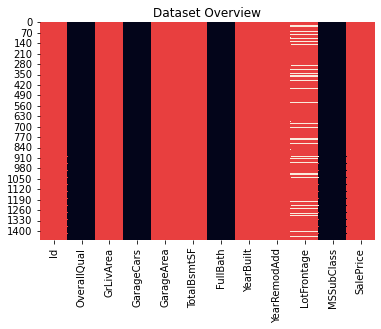

 Categerocial   Numeric   NaN 


In [5]:
dic_cols = {col:utils_recognize_type(dtf, col, max_cat=20) for col in dtf.columns}
heatmap = dtf.isnull()
for k,v in dic_cols.items():
    if v == "num":
        heatmap[k] = heatmap[k].apply(lambda x: 0.6 if x is False else 1)
    else:
        heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)
sns.heatmap(heatmap, cbar=False).set_title('Dataset Overview')
plt.show()
print("\033[6;37;40m Categerocial ", "\033[1;30;41m Numeric ", "\033[1;30;47m NaN ")
# Based on the python ANSI codes, define the background color and tex color.

From the heatmap, we can read that

- There are 1460 rows and 12 columns.
- *OverallQuall, GarageCars, FullBath and MSSubClass*are categorical variables while the others are numerical.
- Only *LotFrontage* contains missing data.
- *SalePrice* is the dependent variable that we want to understand and predict, so I’ll rename the column “*Y*”.

In [6]:
dtf = dtf.set_index("Id")
dtf = dtf.rename(columns={"SalePrice":"Y"})

In [7]:
dtf.head()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,LotFrontage,MSSubClass,Y
Id,,,,,,,,,,,
1,7,1710,2,548,856,2,2003,2003,65.0,60,208500
2,6,1262,2,460,1262,2,1976,1976,80.0,20,181500
3,7,1786,2,608,920,2,2001,2002,68.0,60,223500
4,7,1717,3,642,756,1,1915,1970,60.0,70,140000
5,8,2198,3,836,1145,2,2000,2000,84.0,60,250000


In [8]:
dtf["Y"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: Y, dtype: float64

Let's do some data visualization to check the probability distribution of one variable.

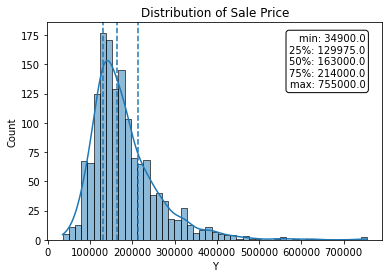

In [9]:
x = "Y"
fig, ax = plt.subplots()
ax.title.set_text('Distribution of Sale Price')
variable = dtf[x].fillna(dtf[x].mean())
sns.histplot(variable, kde=True)
des = dtf[x].describe()
ax.axvline(des["25%"], ls='--')
ax.axvline(des["50%"], ls='--')
ax.axvline(des["75%"], ls='--')
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "50%: "+des["50%"], "75%: "+des["75%"], "max: "+des["max"]))
ax.text(0.95, 0.95, box, transform=ax.transAxes, fontsize=10, va='top', 
        ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))
plt.show()

A box plot to graphically depict data groups through their quartiles. 

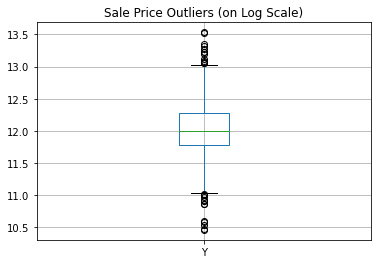

In [10]:
x = "Y"
fig, ax = plt.subplots()
ax.title.set_text('Sale Price Outliers (on Log Scale)')
tmp_dtf = pd.DataFrame(dtf[x])
tmp_dtf[x] = np.log(tmp_dtf[x])
tmp_dtf.boxplot(column=x, ax=ax)
plt.show()

A bar plot is appropriate to understand labels frequency for a single categorical variable.

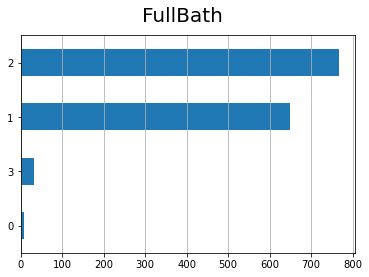

In [11]:
x = "FullBath"
ax = dtf[x].value_counts().sort_values().plot(kind="barh")
ax.grid(axis="x")
plt.suptitle(x, fontsize=20)
plt.show()

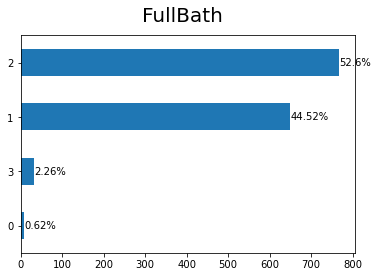

In [12]:
x = "FullBath"
ax = dtf[x].value_counts().sort_values().plot(kind="barh")
totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20, 
     str(round((i.get_width()/total)*100, 2))+'%', 
     fontsize=10, color='black')
#ax.grid(axis="x")
plt.suptitle(x, fontsize=20)
plt.show()

Next, we have to check the bivariate distribution to understand if one variable has predictive power of our dependent variable or not. 

We first check the **categorical vs numerical** case by comparing *FullBath* and *Y*. There are some options to do this:

- Option 1: We can split the population (the whole set of observations) into 4 samples: the portion of houses with 0 bathroom (FullBath = 0), 1 bathroom (FullBath = 1), and so on. Then we plot and compare densities of the 4 samples, if the distributions are different then the variable is predictive because the 4 groups have different patterns.
- Option 2: We can also group the numerical variable (Y) in bins (subsamples) and plot the composition of each bin, if the proportion of the categories is similar in all of them then the variable is not predictive.
- Option 3: The last optoin is to plot and compare the box plots of the 4 samples to spot different behaviors of the outliers.

We first try option 1.

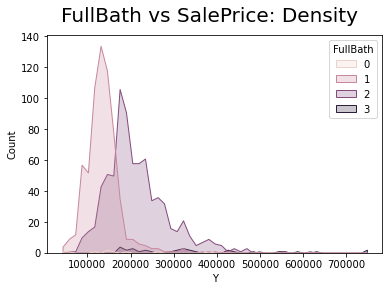

In [13]:
fig, ax = plt.subplots()
fig.suptitle("FullBath vs SalePrice: Density", fontsize=20)
sns.histplot(data = dtf, x = "Y", hue = "FullBath", element="poly")            

Another way to do the work.

C:\Users\pz6755\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\pz6755\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\pz6755\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `k

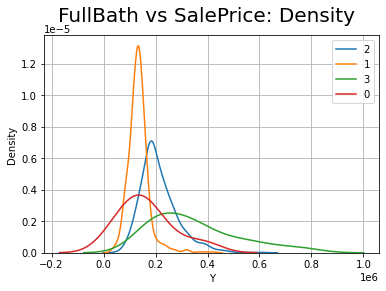

In [14]:
cat, num = "FullBath", "Y"
fig, ax = plt.subplots()
fig.suptitle("FullBath vs SalePrice: Density", fontsize=20)

for i in dtf[cat].unique():
    sns.distplot(dtf[dtf[cat]==i][num], hist=False, label= i, ax=ax)
plt.legend()
ax.grid(True)

Then, let's check option 2.

In [15]:
cat, num = "FullBath", "Y"
breaks = np.quantile(dtf[num], q=np.linspace(0,1,11))
tmp = dtf.groupby([cat, pd.cut(dtf[num], breaks, duplicates='drop')]).size().unstack().T
tmp = tmp[dtf[cat].unique()]
tmp

FullBath,2,1,3,0
Y,,,,
"(34900.0, 106475.0]",23,120,0,2
"(106475.0, 124000.0]",22,126,0,1
"(124000.0, 135500.0]",29,115,0,0
"(135500.0, 147000.0]",45,103,0,2
"(147000.0, 163000.0]",53,89,0,1
"(163000.0, 179280.0]",92,48,4,0
"(179280.0, 198620.0]",126,16,3,1
"(198620.0, 230000.0]",131,14,4,0
"(230000.0, 278000.0]",131,10,2,1


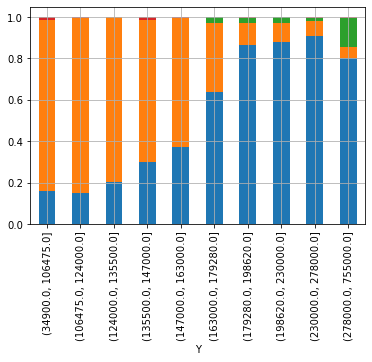

In [16]:
tmp["tot"] = tmp.sum(axis=1)
for col in tmp.drop("tot", axis=1).columns:
    tmp[col] = tmp[col] / tmp["tot"] 
tmp.drop("tot", axis=1).plot(kind='bar', stacked=True, legend=False, grid=True)
plt.show()

Option 3:

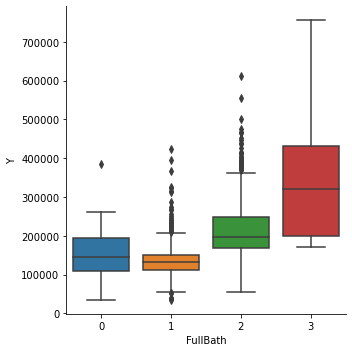

In [17]:
sns.catplot(x=cat, y=num, data=dtf, kind="box")
plt.show()

FullBath is predictive given that the distributions of the 4 samples are very different in price levels and number of observations. It appears that the more bathrooms there are in the house the higher is the price.

However, the “eye intuition” may not be convincing enough since the observations in the 0 bathroom sample and in the 3 bathrooms sample contain very few observations. So we can use a one-way ANOVA test to check the statistical significance. Basically, it tests whether the means of two or more independent samples are significantly different, so if the p-value is small enough (<0.05) the null hypothesis of samples means equality can be rejected.

In [18]:
cat, num = "FullBath", "Y"
model = smf.ols(num+' ~ '+cat, data=dtf).fit()
table = sm.stats.anova_lm(model)
p = table["PR(>F)"][0]
coeff, p = None, round(p, 3)
conclusion = "Correlated" if p < 0.05 else "Non-Correlated"
print("Anova F: the variables are", conclusion, "(p-value: "+str(p)+")")

Anova F: the variables are Correlated (p-value: 0.0)


We can conclude that the number of bathrooms determines a higher price of the house. That makes sense as more bathrooms mean a bigger house and the size of the house is an important price factor.

Next, we check the numerical vs numerical case. Here we use the *GrlivArea* vs *Y* as an example to do the analysis. We have three ways to do the work.

- First, we can group GrLivArea values into bins and compare the mean value (and median) of Y in each bin, if the curve isn’t flat then the variable is predictive because the bins have different patterns.
- Second, we can use a scatter plot with the distributions of the two variables on the sides.
- In the end, since they are both numerical variables, we can test the Pearson’s Correlation Coefficient: assuming that two variables are independent (null hypothesis), it tests whether two samples have a linear relationship. If the p-value is small enough (<0.05), the null hypothesis can be rejected and we can say that the two variables are probably dependent.

                           mean    median  size
GrLivArea                                      
(334.0, 912.0]    109702.973684  114750.0   152
(912.0, 1066.6]   122911.532374  128000.0   139
(1066.6, 1208.0]  134940.127517  140000.0   149
(1208.0, 1339.0]  153247.479167  155000.0   144
(1339.0, 1464.0]  161170.089041  163495.0   146
(1464.0, 1578.0]  184577.342466  179050.0   146
(1578.0, 1709.3]  200277.634483  188700.0   145
(1709.3, 1869.0]  208757.809524  196500.0   147
(1869.0, 2158.3]  239593.806897  228500.0   145
(2158.3, 5642.0]  296058.171233  280606.5   146


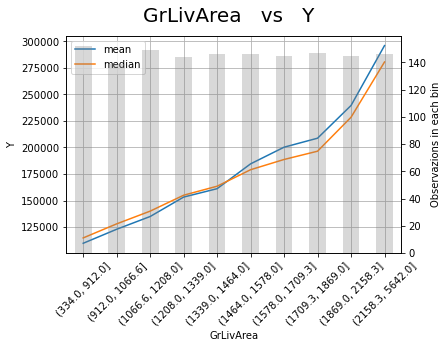

In [19]:
x, y = "GrLivArea", "Y"
### bin plot
dtf_noNan = dtf[dtf[x].notnull()]
breaks = np.quantile(dtf_noNan[x], q=np.linspace(0, 1, 11))
groups = dtf_noNan.groupby([pd.cut(dtf_noNan[x], bins=breaks, 
           duplicates='drop')])[y].agg(['mean','median','size'])
print(groups)
fig, ax = plt.subplots()
fig.suptitle(x+"   vs   "+y, fontsize=20)
groups[["mean", "median"]].plot(kind="line", ax=ax)
groups["size"].plot(kind="bar", ax=ax, rot=45, secondary_y=True,
                    color="grey", alpha=0.3, grid=True)
ax.set(ylabel=y)
ax.right_ax.set_ylabel("Observazions in each bin")
plt.show()

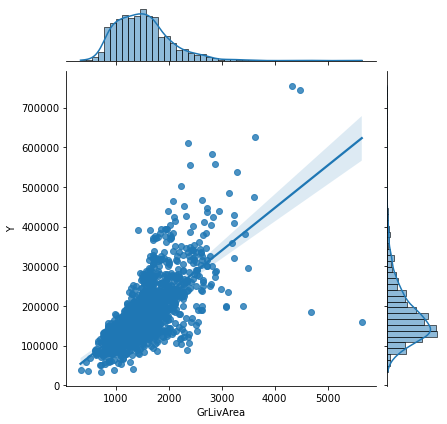

In [20]:
### scatter plot
sns.jointplot(x=x, y=y, data=dtf, dropna=True, kind='reg')
plt.show()

Option 3:

In [21]:
x, y = "GrLivArea", "Y"
dtf_noNan = dtf[dtf[x].notnull()]
coeff, p = scipy.stats.pearsonr(dtf_noNan[x], dtf_noNan[y])
coeff, p = round(coeff, 3), round(p, 3)
conclusion = "Significant" if p < 0.05 else "Non-Significant"
print("Pearson Correlation:", coeff, conclusion, "(p-value: "+str(p)+")")

Pearson Correlation: 0.709 Significant (p-value: 0.0)


It is clear that *GrLivArea* is predictive, there is a clear pattern: on average, the larger the house the higher the price, even though there are some outliers with an above-average size and a relatively low price.

*FullBath* and *GrLivArea* are examples of predictive features. This kind of analysis should be carried on for each variable in the dataset to decide what should be kept as a potential feature and what can be dropped because not predictive 

 ## <font color='red'> Exercise </font>
 
 Can you check some other categorical and numericl variables to see if they have predictive power to predict Y variable or not?

## Feature Engineering

It’s time to create new features from raw data using domain knowledge. Here, we use the *MSSubClass* column (the building class) as an example. This categorical variable contains 15 categories, which is a lot and can cause a dimensionality problem during modeling. 

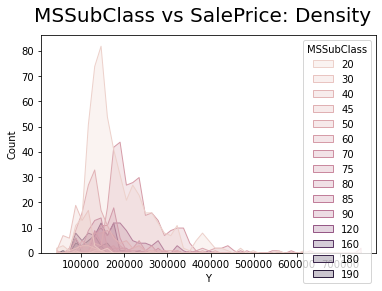

In [26]:
fig, ax = plt.subplots()
fig.suptitle("MSSubClass vs SalePrice: Density", fontsize=20)
sns.histplot(data = dtf, x = "Y", hue = "MSSubClass", element="poly") 

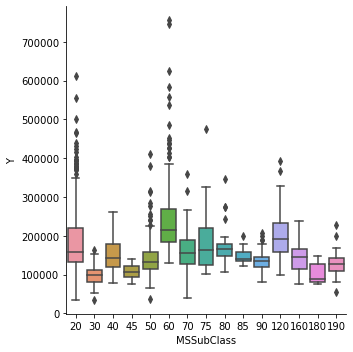

In [27]:
sns.catplot(x="MSSubClass", y="Y", data=dtf, kind="box")

There are many categories and it’s hard to understand what’s the distribution inside each one. We can group these categories into clusters: 
- the classes with higher Y value (like MSSubClass 60 and 120) will go into the “max” cluster, 
- the classes with lower prices (like MSSubClass 30, 45, 180) will go into the “min” cluster, 
- the rest will be grouped into the “mean” cluster.

In [28]:
x, y = "MSSubClass", "Y"
## define clusters
MSSubClass_clusters = {"min":[30,45,180], "max":[60,120], "mean":[]}
## create new columns
dic_flat = {v:k for k,lst in MSSubClass_clusters.items() for v in lst}
for k,v in MSSubClass_clusters.items():
    if len(v)==0:
        residual_class = k 
dtf["MSSubClass"+"_cluster"] = dtf[x].apply(lambda x: dic_flat[x] if x in 
                          dic_flat.keys() else residual_class)
dtf

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,LotFrontage,MSSubClass,Y,MSSubClass_cluster
Id,,,,,,,,,,,,
1,7,1710,2,548,856,2,2003,2003,65.0,60,208500,max
2,6,1262,2,460,1262,2,1976,1976,80.0,20,181500,mean
3,7,1786,2,608,920,2,2001,2002,68.0,60,223500,max
4,7,1717,3,642,756,1,1915,1970,60.0,70,140000,mean
5,8,2198,3,836,1145,2,2000,2000,84.0,60,250000,max
...,...,...,...,...,...,...,...,...,...,...,...,...
1456,6,1647,2,460,953,2,1999,2000,62.0,60,175000,max
1457,6,2073,2,500,1542,2,1978,1988,85.0,20,210000,mean
1458,7,2340,1,252,1152,2,1941,2006,66.0,70,266500,mean


In this way, we reduced the number of categories from 15 to 3. And it is much easier to analysi.

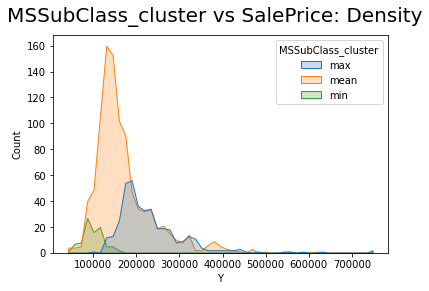

In [29]:
fig, ax = plt.subplots()
fig.suptitle("MSSubClass_cluster vs SalePrice: Density", fontsize=20)
sns.histplot(data = dtf, x = "Y", hue = "MSSubClass_cluster", element="poly") 

## Processing

Data preprocessing is the phase of preparing raw data to make it suitable for a machine learning model. In particular:

- each observation must be represented by a single row, in other words, you can’t have two rows describing the same passenger because they will be processed separately by the model (the dataset is already in such form, so check!). Moreover, each column should be a feature, so you shouldn’t use Id as a predictor, that’s why this kind of table is called “feature matrix”.
- The dataset must be partitioned into at least two sets: the model shall be trained on a significant portion of your dataset (so-called “train set”) and tested on a smaller set (“test set”).
- Missing values should be replaced with something, otherwise, your model may freak out.
- Categorical data must be encoded, which means converting labels into integers because machine learning expects numbers, not strings.
- It’s good practice to scale the data, it helps to normalize the data within a particular range and speed up the calculations in an algorithm.

Let’s begin by **partitioning** the dataset. When splitting data into train and test sets you must follow 1 basic rule: rows in the train set shouldn’t appear in the test set as well. 

In [30]:
## split data
dtf_train, dtf_test = model_selection.train_test_split(dtf, 
                      test_size=0.3)
## print info
print("X_train shape:", dtf_train.drop("Y",axis=1).shape, "| X_test shape:", dtf_test.drop("Y",axis=1).shape)
print("y_train mean:", round(np.mean(dtf_train["Y"]),2), "| y_test mean:", round(np.mean(dtf_test["Y"]),2))
print(dtf_train.shape[1], "features:", dtf_train.drop("Y",axis=1).columns.to_list())

X_train shape: (1022, 11) | X_test shape: (438, 11)
y_train mean: 182182.91 | y_test mean: 177977.2
12 features: ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'LotFrontage', 'MSSubClass', 'MSSubClass_cluster']


Next step: the *LotFrontage* column contains some **missing data** (17%) that need to be handled. From a Machine Learning perspective, it’s correct to first split into train and test and then replace NAs with the average of the training set.

In [31]:
dtf_train["LotFrontage"].isnull().sum()

168

In [32]:
dtf_train["LotFrontage"].fillna(dtf_train["LotFrontage"].mean(), inplace = True)

C:\Users\pz6755\Anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [33]:
dtf_train["LotFrontage"].isnull().sum()

0

The new column we just created *MSSubClass_cluster* contains **categorical data** that should be encoded. We use the One-Hot-Encoding method, transforming 1 categorical column with n unique values into n-1 dummies.

In [34]:
## create dummy
dummy = pd.get_dummies(dtf_train["MSSubClass_cluster"], 
                       prefix="MSSubClass_cluster",drop_first=True)
dtf_train= pd.concat([dtf_train, dummy], axis=1)
print( dtf_train.filter(like="MSSubClass_cluster",axis=1).head() )
## drop the original categorical column
dtf_train = dtf_train.drop("MSSubClass_cluster", axis=1)

    MSSubClass_cluster  MSSubClass_cluster_mean  MSSubClass_cluster_min
Id                                                                     
824               mean                        1                       0
433               mean                        1                       0
982                max                        0                       0
401                max                        0                       0
797               mean                        1                       0


In [35]:
dtf_train

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,LotFrontage,MSSubClass,Y,MSSubClass_cluster_mean,MSSubClass_cluster_min
Id,,,,,,,,,,,,,
824,6,1489,1,240,778,2,1940,1950,60.000000,50,139500,1,0
433,5,1365,2,440,765,1,1971,1971,24.000000,160,122500,1,0
982,8,2612,3,676,1225,2,1998,1999,98.000000,60,336000,0,0
401,8,1288,2,500,1260,1,1996,1996,38.000000,120,245500,0,0
797,6,1285,2,528,660,1,1977,1977,71.000000,20,143500,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,5,1302,1,280,630,2,1971,1971,21.000000,160,112000,1,0
1263,4,1788,1,304,1104,1,1957,1989,70.004684,50,161500,1,0
1452,8,1578,3,840,1573,2,2008,2009,78.000000,20,287090,1,0


Last but not least, we are going to **scale the features**. For regression problems, it is often desirable to transform both the input and the target variables. We use the RobustScaler which transforms the feature by subtracting the median and then dividing by the interquartile range (75% value — 25% value). The advantage of this scaler is that it’s less affected by outliers.

In [36]:
## scale X
scalerX = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
X = scalerX.fit_transform(dtf_train.drop("Y", axis=1))
dtf_train_scaled= pd.DataFrame(X, columns=dtf_train.drop("Y", 
                        axis=1).columns, index=dtf_train.index)
## scale Y
scalerY = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
dtf_train_scaled[y] = scalerY.fit_transform(dtf_train[y].values.reshape(-1,1))
dtf_train_scaled.head()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,LotFrontage,MSSubClass,MSSubClass_cluster_mean,MSSubClass_cluster_min,Y
Id,,,,,,,,,,,,,
824,0.0,0.050750,-1.0,-0.884470,-0.429607,0.0,-0.680851,-1.131579,-0.500234,0.0,0.0,0.0,-0.289719
433,-0.5,-0.139946,0.0,-0.126894,-0.456522,-1.0,-0.021277,-0.578947,-2.300234,2.2,0.0,0.0,-0.491200
982,1.0,1.777778,1.0,0.767045,0.495859,0.0,0.553191,0.157895,1.399766,0.2,-1.0,0.0,2.039170
401,1.0,-0.258362,0.0,0.100379,0.568323,-1.0,0.510638,0.078947,-1.600234,1.4,-1.0,0.0,0.966578
797,0.0,-0.262976,0.0,0.206439,-0.673913,-1.0,0.106383,-0.421053,0.049766,-0.6,0.0,0.0,-0.242311


## <font color='red'> Exercise </font>

Can you do the processing for the test data set?

## Feature Selection

**Feature selection** is the process of selecting a subset of relevant variables to build the machine learning model. It makes the model easier to interpret and reduces overfitting (when the model adapts too much to the training data and performs badly outside the train set).

We already did a first “manual” feature selection during data analysis by excluding irrelevant columns. Now it’s going to be a bit different because we have to deal with the **multicollinearity** problem, which refers to a situation in which two or more explanatory variables in a multiple regression model are highly linearly related.

For example: *GarageCars* is highly correlated with *GarageArea* because they both give the same information (how big the garage is, one in terms of how many cars can fit, the other in square feet). Let’s compute the correlation matrix to see it:

Text(0.5, 1.0, 'pearson correlation')

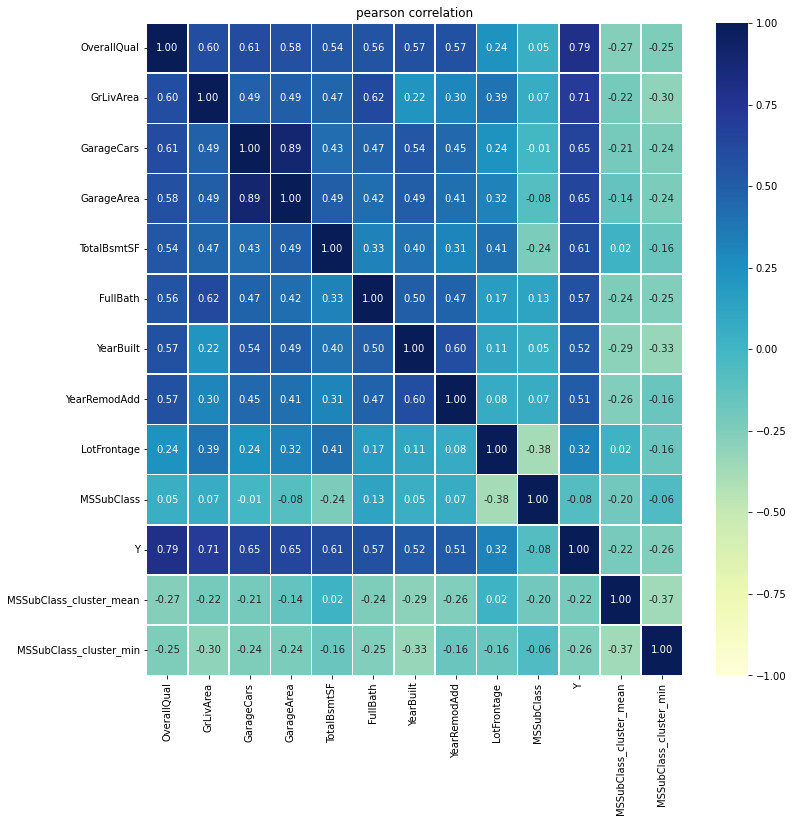

In [40]:
fig, ax = plt.subplots(figsize=(12,12))      
corr_matrix = dtf_train.corr(method="pearson")
sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5, ax = ax)
plt.title("pearson correlation")

One among *GarageCars* and *GarageArea* could be unnecessary and we may decide to drop it and keep the most useful one (i.e. the one with the lowest p-value or the one that most reduces entropy).

There are two methods to do the work:
- **Linear regression** is a linear approach to modeling the relationship between a scalar response and one or more explanatory variables. Univariate linear regression tests are widely used for testing the individual effect of each of many regressors: first, the correlation between each regressor and the target is computed, then an ANOVA F-test is performed.
- **RIDGE regularization** is particularly useful to mitigate the problem of multicollinearity in linear regression, which commonly occurs in models with large numbers of parameters.

We check both methods here:

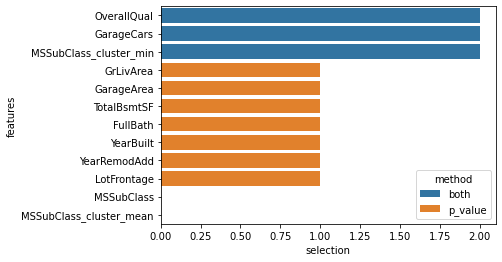

In [41]:
X = dtf_train.drop("Y", axis=1).values
y = dtf_train["Y"].values
feature_names = dtf_train.drop("Y", axis=1).columns
## p-value
selector = feature_selection.SelectKBest(score_func= feature_selection.f_regression, k=10).fit(X,y)
pvalue_selected_features = feature_names[selector.get_support()]

## regularization
selector = feature_selection.SelectFromModel(estimator= 
              linear_model.Ridge(alpha=1.0, fit_intercept=True), 
                                 max_features=10).fit(X,y)
regularization_selected_features = feature_names[selector.get_support()]


## plot
dtf_features = pd.DataFrame({"features":feature_names})
dtf_features["p_value"] = dtf_features["features"].apply(lambda x: "p_value" if x in pvalue_selected_features else "")
dtf_features["num1"] = dtf_features["features"].apply(lambda x: 1 if x in pvalue_selected_features else 0)
dtf_features["regularization"] = dtf_features["features"].apply(lambda x: "regularization" if x in regularization_selected_features else "")
dtf_features["num2"] = dtf_features["features"].apply(lambda x: 1 if x in regularization_selected_features else 0)
dtf_features["method"] = dtf_features[["p_value","regularization"]].apply(lambda x: (x[0]+" "+x[1]).strip(), axis=1)
dtf_features["selection"] = dtf_features["num1"] + dtf_features["num2"]
dtf_features["method"] = dtf_features["method"].apply(lambda x: "both" if len(x.split()) == 2 else x)
sns.barplot(y="features", x="selection", hue="method", data=dtf_features.sort_values("selection", ascending=False), dodge=False)

As the plot shown, the blue features are the ones selected by both ANOVA and RIDGE, the others are selected by just the first statistical method.

Alternatively, we can use **ensemble methods** to get feature importance. Ensemble methods use multiple learning algorithms to obtain better predictive performance than could be obtained from any of the constituent learning algorithms alone. 

We will give an example using a **gradient boosting algorithm**: it builds an additive model in a forward stage-wise fashion and in each stage fits a regression tree on the negative gradient of the given loss function.

    IMPORTANCE                 VARIABLE
0     0.535621              OverallQual
1     0.180230                GrLivArea
4     0.101945              TotalBsmtSF
2     0.074028               GarageCars
7     0.028537             YearRemodAdd
5     0.023780                 FullBath
6     0.019880                YearBuilt
3     0.017356               GarageArea
8     0.015555              LotFrontage
9     0.002901               MSSubClass
10    0.000166  MSSubClass_cluster_mean
11    0.000000   MSSubClass_cluster_min


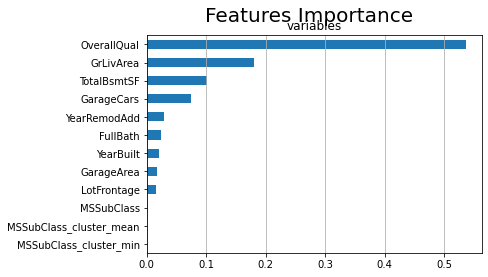

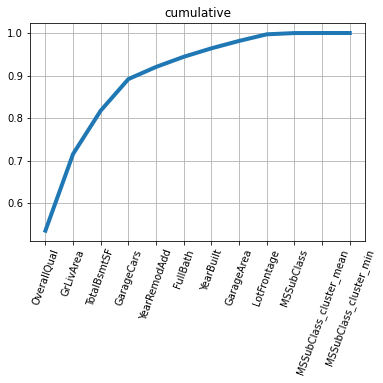

In [42]:
X = dtf_train.drop("Y", axis=1).values
y = dtf_train["Y"].values
feature_names = dtf_train.drop("Y", axis=1).columns.tolist()
## call model
model = ensemble.GradientBoostingRegressor()
## Importance
model.fit(X,y)
importances = model.feature_importances_
## Put in a pandas dtf
dtf_importances = pd.DataFrame({"IMPORTANCE":importances, 
            "VARIABLE":feature_names}).sort_values("IMPORTANCE", 
            ascending=False)
print(dtf_importances)
dtf_importances['cumsum'] = dtf_importances['IMPORTANCE'].cumsum(axis=0)
dtf_importances = dtf_importances.set_index("VARIABLE")

## Plot
#fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
fig, ax = plt.subplots()
fig.suptitle("Features Importance", fontsize=20)
ax.title.set_text('variables')
dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(
                kind="barh", legend=False, ax=ax).grid(axis="x")
ax.set(ylabel="")
plt.show()
fig, ax = plt.subplots()
ax.title.set_text('cumulative')
dtf_importances[["cumsum"]].plot(kind="line", linewidth=4, legend=False, ax=ax)
ax.set(xlabel="", xticks=np.arange(len(dtf_importances)), xticklabels=dtf_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')
plt.show()

In [43]:
dtf_test

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,LotFrontage,MSSubClass,Y,MSSubClass_cluster_mean,MSSubClass_cluster_min
Id,,,,,,,,,,,,,
787,5,1652,1,416,686,2,1915,1950,60.000000,50,139000,1,0
1018,8,1360,2,565,1220,1,1984,1984,70.161383,120,187500,0,0
64,7,1710,2,480,576,2,1921,1950,50.000000,70,140000,1,0
174,6,1362,2,504,1362,1,1961,1961,80.000000,20,163000,1,0
52,6,1176,2,528,816,1,1934,1950,52.000000,50,114500,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
464,6,1660,1,240,715,1,1934,1995,74.000000,70,188700,1,0
1314,9,2599,3,779,1393,2,1999,1999,108.000000,60,333168,0,0
601,8,1904,2,736,1058,2,2005,2005,74.000000,60,275000,0,0


It’s really interesting that *OverallQual*, *GrLivArea* and *TotalBsmtSf* dominate in all the methods presented. So we select these three and proceed with the design, train, test, and evaluation of the machine learning model.

Please note that before using test data for prediction we have to preprocess it just like we did for the train data.

We select the following variables as an example and proceed with the design, train, test, and evaluation of the machine learning model:

In [44]:
X_names = ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageCars']
X_train = dtf_train_scaled[X_names].values
y_train = dtf_train_scaled["Y"].values
X_test = dtf_test_scaled[X_names].values
y_test = dtf_test_scaled["Y"].values

## Model Design

Finally, it’s time to build the machine learning model. We first run a simple linear regression and use it as a baseline.

The most common metric we normally use is the **R squared**, which indicates the proportion of the variance in the dependent variable that is predictable from the independent variable.

We can compare the linear regression R squared with the gradient boosting’s one using **k-fold cross-validation**, a procedure that consists in splitting the data k times into train and validation sets and for each split, the model is trained and tested. It’s used to check how well the model is able to get trained by some data and predict unseen data.

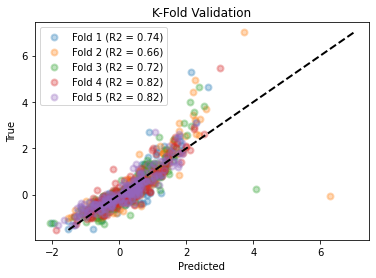

In [45]:
## call model
model = linear_model.LinearRegression()
## K fold validation
scores = []
cv = model_selection.KFold(n_splits=5, shuffle=True)
fig = plt.figure()
i = 1
for train, test in cv.split(X_train, y_train):
    prediction = model.fit(X_train[train],
                 y_train[train]).predict(X_train[test])
    true = y_train[test]
    score = metrics.r2_score(true, prediction)
    scores.append(score)
    plt.scatter(prediction, true, lw=2, alpha=0.3, 
                label='Fold %d (R2 = %0.2f)' % (i,score))
    i = i+1
plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], 
         linestyle='--', lw=2, color='black')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('K-Fold Validation')
plt.legend()
plt.show()

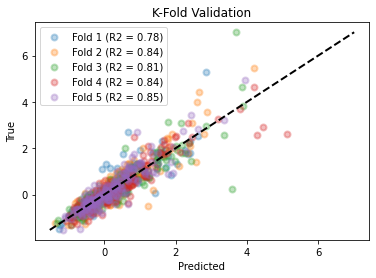

In [46]:
model = ensemble.GradientBoostingRegressor()
param_dic = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001],      
             #weighting factor for the corrections by new trees when added to the model
             'n_estimators':[100,250,500,750,1000,1250,1500,1750],  
             #number of trees added to the model
             'max_depth':[2,3,4,5,6,7],                             
             #maximum depth of the tree
             'min_samples_split':[2,4,6,8,10,20,40,60,100],         
             #sets the minimum number of samples to split
             'min_samples_leaf':[1,3,5,7,9],                        
             #the minimum number of samples to form a leaf
             'max_features':[2,3,4,5,6,7],                          
             #square root of features is usually a good starting point
             'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]            
             #the fraction of samples to be used for fitting the individual base learners. Values lower than 1
            }
## K fold validation
scores = []
cv = model_selection.KFold(n_splits=5, shuffle=True)
fig = plt.figure()
i = 1
for train, test in cv.split(X_train, y_train):
    prediction = model.fit(X_train[train],
                 y_train[train]).predict(X_train[test])
    true = y_train[test]
    score = metrics.r2_score(true, prediction)
    scores.append(score)
    plt.scatter(prediction, true, lw=2, alpha=0.3, 
                label='Fold %d (R2 = %0.2f)' % (i,score))
    i = i+1
plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], 
         linestyle='--', lw=2, color='black')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('K-Fold Validation')
plt.legend()
plt.show()

The gradient boosting model presents better performances, so we use it to predict test data:

In [47]:
## train
model.fit(X_train, y_train)
## test
predicted = model.predict(X_test)

Remember that data were scaled, therefore in order to compare the predictions with the actual house prices in the test set they must be unscaled (with the inverse transform function):

In [48]:
predicted = scalerY.inverse_transform(predicted.reshape(-1,1) ).reshape(-1)
y_test = scalerY.inverse_transform(y_test.reshape(-1,1) ).reshape(-1)

## Evaluation

Moment of truth, we’re about to see if all this hard work is worth it. The whole point is to study how much variance of Y the model can explain and how the errors are distributed.

We will evaluate the model using the following common metrics: **R squared**, **mean absolute error (MAE)**, and **root mean squared error (RMSD)**. The last two are measures of error between paired observations expressing the same phenomenon. Since errors can be both positive (actual > prediction) and negative (actual < prediction), you can measure the absolute value and the squared value of each error.

In [49]:
## Kpi
print("R2 (explained variance):", round(metrics.r2_score(y_test, predicted), 2))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", round(np.mean(np.abs((y_test-predicted)/predicted)), 2))
print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,.0f}".format(np.sqrt(metrics.mean_squared_error(y_test, predicted))))
## residuals
residuals = y_test - predicted
max_error = max(residuals) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(residuals).index(min(residuals))
max_true, max_pred = y_test[max_idx], predicted[max_idx]
print("Max Error:", "{:,.0f}".format(max_error))

R2 (explained variance): 0.84
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.13
Mean Absolute Error (Σ|y-pred|/n): 21,788
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 30,168
Max Error: 144,213


The model explains 84\% of the variance of the target variable. On average, predictions have an error of 21.8k, or they’re wrong by 13%. The biggest error on the test set was over 144k. We can visualize the errors by plotting predicted against actuals and the residual (the error) of each prediction.

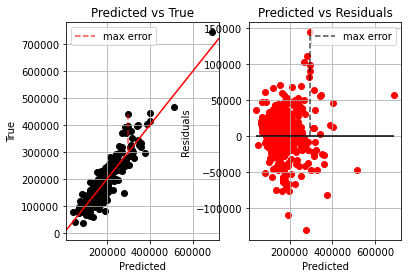

In [55]:
## Plot predicted vs true
fig, ax = plt.subplots(nrows=1, ncols=2)
from statsmodels.graphics.api import abline_plot
ax[0].scatter(predicted, y_test, color="black")
abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
ax[0].vlines(x=max_pred, ymin=max_true, ymax=max_true-max_error, color='red', linestyle='--', alpha=0.7, label="max error")
ax[0].grid(True)
ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
ax[0].legend()
    
## Plot predicted vs residuals
ax[1].scatter(predicted, residuals, color="red")
ax[1].vlines(x=max_pred, ymin=0, ymax=max_error, color='black', linestyle='--', alpha=0.7, label="max error")
ax[1].grid(True)
ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
ax[1].hlines(y=0, xmin=np.min(predicted), xmax=np.max(predicted))
ax[1].legend()
plt.show()

C:\Users\pz6755\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


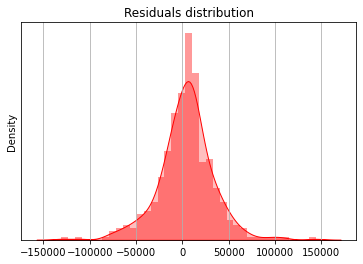

In [56]:
fig, ax = plt.subplots()
sns.distplot(residuals, color="red", hist=True, kde=True, kde_kws={"shade":True}, ax=ax)
ax.grid(True)
ax.set(yticks=[], yticklabels=[], title="Residuals distribution")
plt.show()

## Explainability

We analyzed and understood the data, we trained a model and tested it, we’re even satisfied with the performance. Now we can go the extra mile and show that our machine learning model is not a black box.

The *Lime* package can help us to build an explainer. To give an illustration we will take a random observation from the test set and see what the model predicts:

In [57]:
print("True:", "{:,.0f}".format(y_test[1]), "--> Pred:", "{:,.0f}".format(predicted[1]))

True: 187,500 --> Pred: 207,260


The model predicted a price for this house of 207,260. Why? Let’s use the explainer:

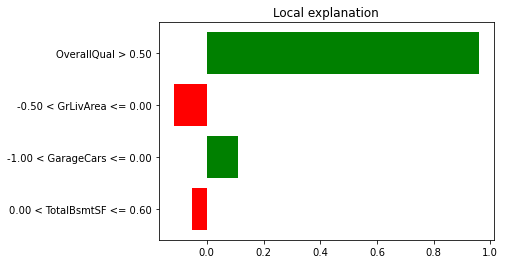

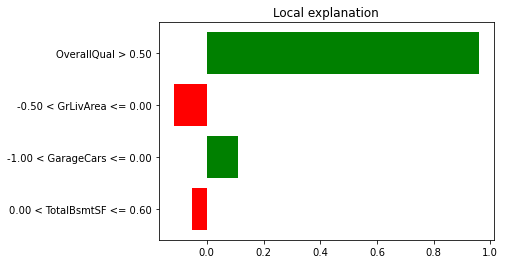

In [60]:
explainer = lime_tabular.LimeTabularExplainer(training_data=X_train, feature_names=X_names, class_names="Y", mode="regression")
explained = explainer.explain_instance(X_test[1], model.predict, num_features=10)
explained.as_pyplot_figure()